# VAE implementation for the MNIST dataset.
* The Goal is to implement VAE with less than 10k parameters in each encoder and decoder while achieving >= 92% pixel reconstruction accuracy.

In [1]:
import numpy as np
np.random.seed(31)
import matplotlib.pyplot as plt

import torch
torch.manual_seed(31)
import torch.distributions as dist
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

from pathlib import Path
from itertools import chain

import utils

DATA_PATH = Path('.').absolute().parent / 'data'

# create data path;
if not DATA_PATH.exists():
    DATA_PATH.mkdir(parents=True)

In [2]:
mnist_transforms = transforms.Compose([transforms.ToTensor(), 
                                       transforms.Lambda(lambda x: x.round())])
FETCHER_PARAMS = {
    "download": True,
    "train": True,
    "transform": mnist_transforms
}
mnist_dataset = utils.get_iters(DATA_PATH, MNIST, **FETCHER_PARAMS)
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)

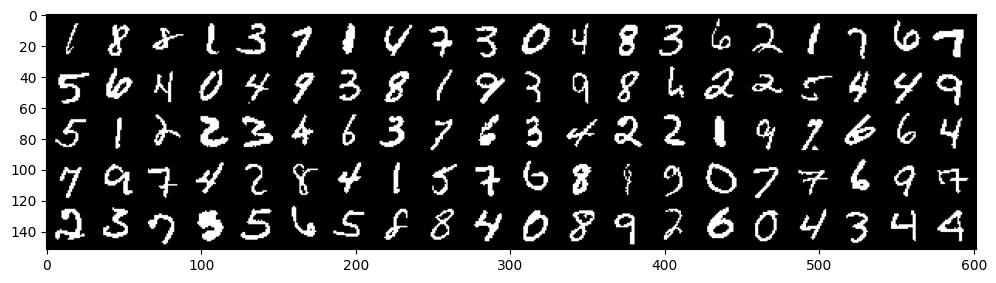

In [3]:
# visualise 100 numbers;
plt.figure(figsize=(12,5))
X_random_batch, y_random_batch = next(iter(train_loader))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0));

In [4]:
print(f"number of images: {len(mnist_dataset)}")

number of images: 60000


## Instantiate Encoder and Decoder nets and start training the VAE.

In [5]:
D_latent = 10

enc = utils.Encoder(D_latent)
dec = utils.Decoder(D_latent)

opt_vae = torch.optim.Adam(chain(enc.parameters(), dec.parameters()))

In [6]:
print(enc)

Encoder(
  (conv_blocks): Sequential(
    (0): ConvBlock(
      (net): Sequential(
        (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
        (2): ReLU()
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ConvBlock(
      (net): Sequential(
        (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
        (2): ReLU()
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=125, out_features=20, bias=True)
  )
)


In [7]:
print(dec)

Decoder(
  (net): Sequential(
    (0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=10, out_features=53, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=53, out_features=23, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=23, out_features=308, bias=True)
  )
)


### Check number of parameters in encoder and decoder.

In [8]:
with torch.no_grad():
    enc_params = sum([p.numel() for p in enc.parameters()])
    dec_params = sum([p.numel() for p in dec.parameters()])
    print(f"encoder params: {enc_params}",
         f"decoder params: {dec_params}", 
          f"total params: {enc_params + dec_params}",
          sep='\n')

encoder params: 2756
decoder params: 9559
total params: 12315


### Start training;

In [9]:
N_epochs = 10
utils.run_training(N_epochs, enc, dec, opt_vae, train_loader, len(mnist_dataset))

Epoch 0, train loss = 234.0580
Epoch 1, train loss = 161.3651
Epoch 2, train loss = 135.5150
Epoch 3, train loss = 125.7784
Epoch 4, train loss = 121.6131
Epoch 5, train loss = 119.3893
Epoch 6, train loss = 118.0519
Epoch 7, train loss = 117.0818
Epoch 8, train loss = 116.4542
Epoch 9, train loss = 115.9881


## Check the results of the training;

In [10]:
def my_reconst_error(val_dataset, val_loader, enc, dec):
    """Calculate average number of correct pixel reconstructions across val_loader."""
    enc.eval(); dec.eval()
    rec_error = 0.
    with torch.no_grad():
        for X, _ in val_loader:
            err = (X != dec(enc(X).sample()).sample()).float().sum().item() / (len(val_dataset) * 28 * 28)
            rec_error += err
    return rec_error

In [11]:
rec_train_error = my_reconst_error(
    mnist_dataset,
    train_loader, 
    enc, 
    dec
)
print(f"avg_reconstruction_train_error: {rec_train_error:.5f}")

avg_reconstruction_train_error: 0.07915


In [12]:
# take best looking reconstruction;
best_batch, best_err = None, None
enc.eval(), dec.eval()
for X, _ in train_loader:
    with torch.no_grad():
        err = (X != dec(enc(X).sample()).sample()).float().mean().item()
        if best_err is None or best_err > err:
            best_err = err
            best_batch = X.detach().clone()

In [13]:
print(f"best_avg_batch_error: {best_err:.3f}")

best_avg_batch_error: 0.071


Reconstruction accuracy: 0.93


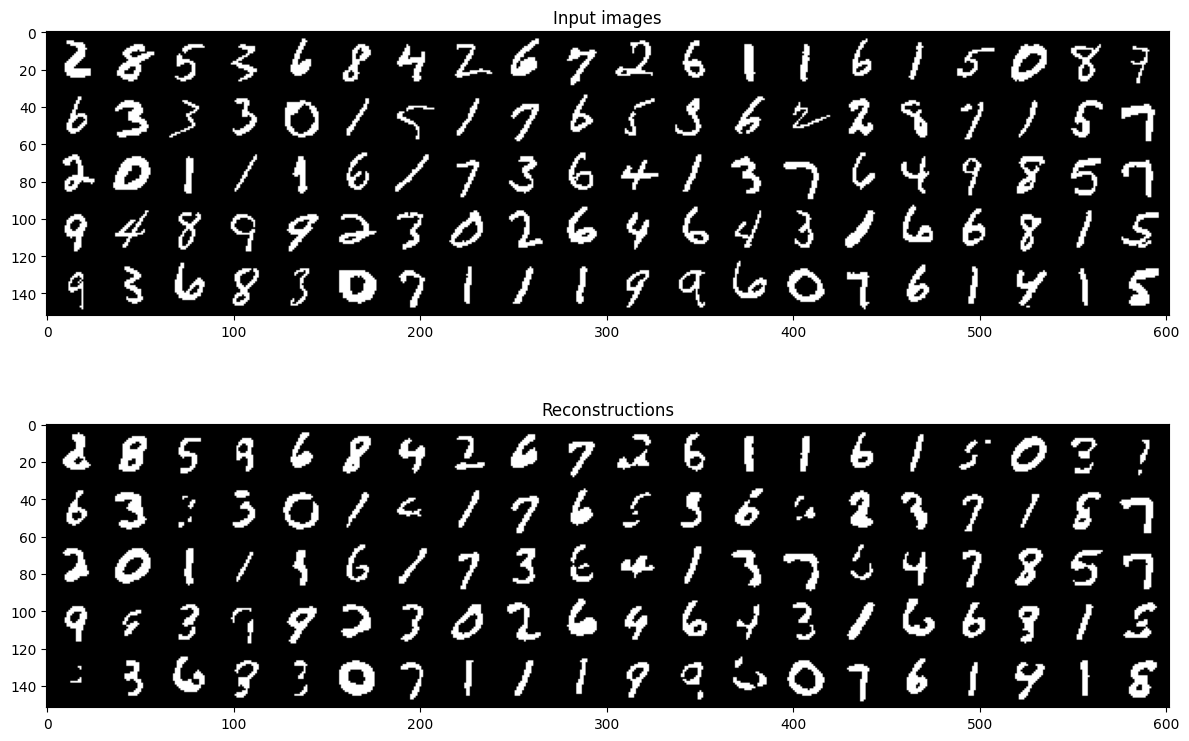

In [14]:
fig, axs = plt.subplots(nrows=2, figsize=(12, 8))
# fig = plt.figure(figsize=(12, 4))
axs[0].imshow(make_grid(best_batch, nrow=20).permute(1,2,0))
axs[0].set_title("Input images")
with torch.no_grad():
    enc.eval()
    dec.eval()
    axs[1].imshow(make_grid(dec(enc(best_batch).sample()).mean.round(), nrow=20).permute(1,2,0))
axs[1].set_title("Reconstructions")
fig.tight_layout()
plt.savefig("vae.png")
acc = (
    best_batch == dec(enc(best_batch).sample()).sample()
).float().mean().item()
print(f"Reconstruction accuracy: {acc:.2f}")